In [9]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorbayes.layers import constant as Constant 
from tensorbayes.layers import placeholder as Placeholder
from tensorbayes.layers import dense as Dense
from tensorbayes.layers import gaussian_sample as GaussianSample
from tensorbayes.distributions import log_bernoulli_with_logits, log_normal
from tensorbayes.tbutils import softmax_cross_entropy_with_two_logits as cross_entropy_with_logits
from tensorbayes.nbutils import show_graph
from tensorbayes.utils import progbar
import numpy as np
import sys
from shared_subgraphs import qy_graph, qz_graph, labeled_loss
from utils import train
print('completed')

completed


In [10]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## M2 Model

We can train Kingma's original M2 model in an unsupervised fashion.

In [14]:
def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(x)
    with tf.variable_scope('px'):
        zy = tf.concat((z, y),1, name='zy/concat')
        h1 = Dense(zy, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return px_logit

In [15]:
tf.reset_default_graph()
# print(Placeholder)
x = Placeholder((None, 784), name = 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y    
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, px_logit = [[None] * 10 for i in xrange(4)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], Constant(0), Constant(1))
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [16]:
show_graph(tf.get_default_graph().as_graph_def())

In [17]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [18]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=2)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.87e+07, -1.87e+07,  1.88e+07, -1.88e+07,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.49e+08, -1.49e+08,  1.51e+08, -1.51e+08,  1.14e-01,         2


# Modified M2 (Gaussian mixture hidden layer)

With some thought, we can modified M2 to implicitly be a latent variable model with a Gaussian mixture stochastic layer. Training is a bit finnicky, so you might have to run it a few times before it works properly.

In [ ]:
method = 'relu'

def custom_layer(zy, reuse):
    # Here are 3 choices for what to do with zy
    # I leave this as hyperparameter
    if method == 'identity':
        return zy
    elif method == 'relu':
        return tf.nn.relu(zy)
    elif method == 'layer':
        return Dense(zy, 512, 'layer1', tf.nn.relu, reuse=reuse)
    else:
        raise Exception('Undefined method')

def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- transform z to be a sample from one of the Gaussian mixture components
    with tf.variable_scope('z_transform'):
        zm = Dense(y, 64, 'zm', reuse=reuse)
        zv = Dense(y, 64, 'zv', tf.nn.softplus, reuse=reuse)
    # -- p(x)
    with tf.variable_scope('px'):
        with tf.name_scope('layer1'):
            zy = zm + tf.sqrt(zv) * z
            h1 = custom_layer(zy, reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return px_logit

In [21]:
tf.reset_default_graph()
x = Placeholder((None, 784), name ='x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y    
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, px_logit = [[None] * 10 for i in xrange(4)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], Constant(0), Constant(1))
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [22]:
show_graph(tf.get_default_graph().as_graph_def())

In [23]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

In [24]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=2)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.97e+07, -1.97e+07,  1.99e+07, -1.99e+07,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.58e+08, -1.58e+08,  1.60e+08, -1.60e+08,  1.14e-01,         2


# Explicit Gaussian Mixture VAE

Why be implicit when we can explicitly train a Gaussian Mixture VAE? So here's code for doing that. Unlike the modified M2, GMVAE is very stable. 

In [25]:
def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(z)
    with tf.variable_scope('pz'):
        zm = Dense(y, 64, 'zm', reuse=reuse)
        zv = Dense(y, 64, 'zv', tf.nn.softplus, reuse=reuse)
    # -- p(x)
    with tf.variable_scope('px'):
        h1 = Dense(z, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return zm, zv, px_logit

In [27]:
tf.reset_default_graph()
x = Placeholder((None, 784), name = 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, zm_prior, zv_prior, px_logit = [[None] * 10 for i in xrange(6)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        zm_prior[i], zv_prior[i], px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], zm_prior[i], zv_prior[i])
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [28]:
show_graph(tf.get_default_graph().as_graph_def())

In [29]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

In [30]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=2)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  2.19e+07, -2.19e+07,  2.23e+07, -2.23e+07,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.77e+08, -1.77e+08,  1.80e+08, -1.80e+08,  1.14e-01,         2


# Evaluation

In [1]:
import glob
import pandas as pd
import seaborn as sns
import os.path
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def prune_rows(arr, k):
    delete_rows = []
    for i in xrange(len(arr)):
        if np.isnan(arr[i, k]):
            delete_rows += [i]
    return np.delete(arr, delete_rows, axis=0)[:, :k]

def plot_from_csv(glob_str, axes, color_idx):
    dfs = [pd.read_csv(f) for f in glob.glob('logs/{:s}.log*'.format(glob_str))]
    df = (pd.concat(dfs, axis=1, keys=range(len(dfs)))
                .swaplevel(0, 1, axis=1)  
                .sortlevel(axis=1))
    df = df[:200].apply(pd.to_numeric)   
    k = 199
    ax1, ax2, ax3 = axes

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_ent')].values.T, k), 
               ax=ax1, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax1.set_ylim(0,3)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Conditional Entropy')

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_loss')].values.T, k), 
               ax=ax2, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_acc')].values.T, k), 
               ax=ax3, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

/home/attack/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
/home/attack/anaconda3/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


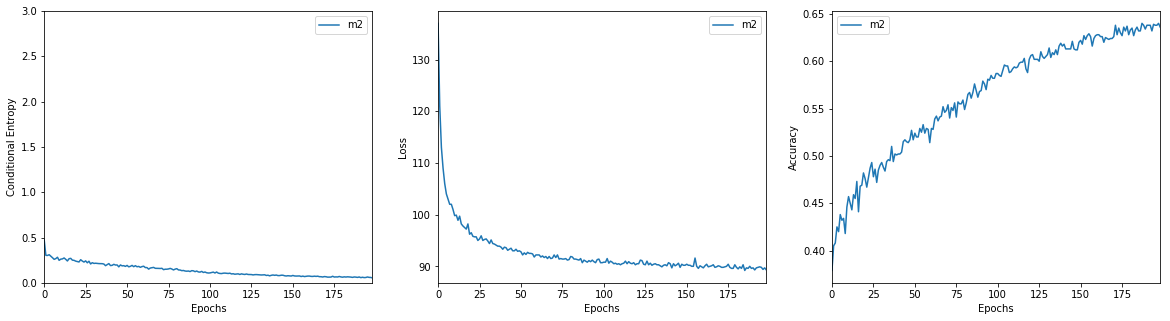

In [5]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('m2', axes, 0)
plt.savefig('images/m2.png')

/home/attack/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


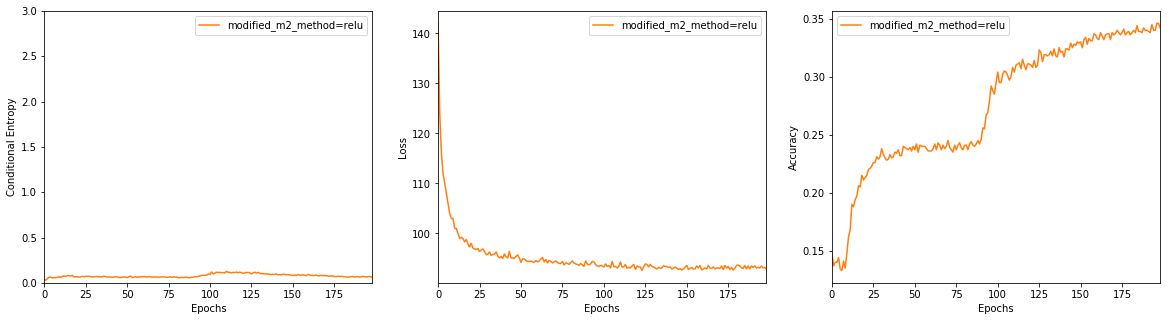

In [6]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('modified_m2_method=relu', axes, 1)
plt.savefig('images/modified_m2_method=relu.png')

/home/attack/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


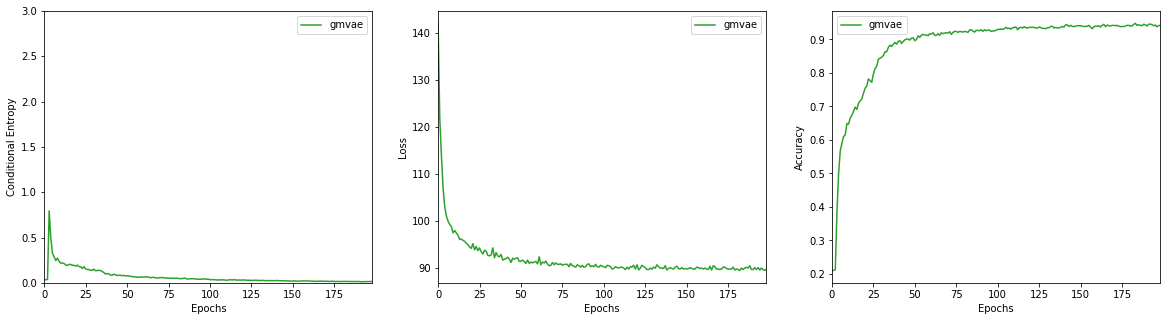

In [7]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('gmvae', axes, 2)
plt.savefig('images/gmvae.png')

/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if sys.path[0] == '':


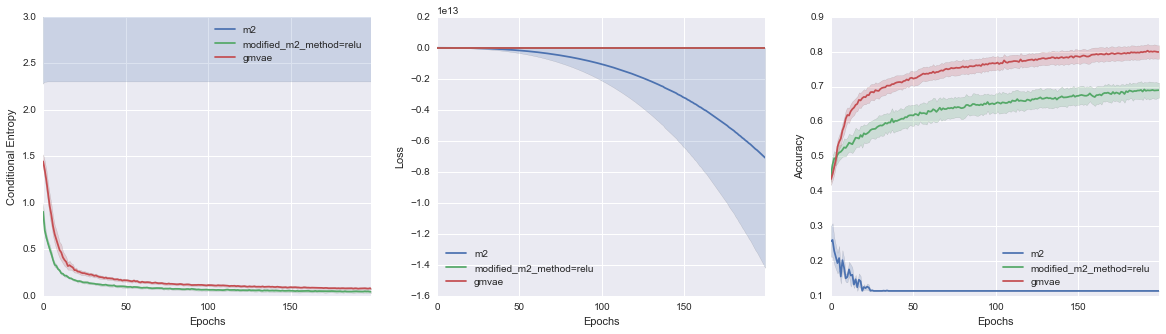

In [38]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('m2', axes, 0)
plot_from_csv('modified_m2_method=relu', axes, 1)
plot_from_csv('gmvae', axes, 2)
plt.savefig('images/combined.png')